# Google vs

From this blog post >> https://medium.com/applied-data-science/the-google-vs-trick-618c8fd5359f

See another implementation here > https://github.com/ekerstein/egograph

In [1]:
import requests
import re
import time


def get_top(seed, orig=None):
    """
    Get the top suggestions for a given seed word.
    """
    if orig is None:
        orig = seed

    params = {
        'output': 'toolbar',
        'hl': 'en',
        'q': f"{seed} vs ",
    }

    # Rate limit a bit.
    time.sleep(0.5)
    URL = "http://suggestqueries.google.com/complete/search"
    r = requests.get(URL, params)
    
    # Get the suggs from the API query.
    suggs = []
    for s in re.findall(r'suggestion data="(.+?)"', r.text):
        try:
            sugg = s.split(' vs ')[1]
        except IndexError:
            sugg = None
        suggs.append(sugg)

    # Clean them up.
    top = []
    for sugg in suggs:
        if sugg is None:
            continue
        if (orig in sugg) or (seed in sugg):
            continue
        sugg = sugg.replace(' 2020', '')
        sugg = sugg.replace(' ', '-')
        try:
            # Get rid of things that are just numbers.
            s = float(sugg)
            continue
        except:
            pass
        
        # Add it.
        if sugg not in top:
            top.append(sugg)
            
        # Stop when we have 5 (or before).
        if len(top) == 5:
            break

    return top

In [2]:
seed = 'geophysics'

get_top(seed)

['geology', 'physics']

## Do the recursive lookup

...and count everything.

In [3]:
from collections import Counter


def get_nodes(seed):
    """
    Use recursion, they said. 
    
    No, I said.
    
    But I agree that this is gross.
    
    Going to go to 3 levels.
    """
    done = []
    c = Counter({seed: 5})  # Why 5?
    d = Counter()
    top = get_top(seed)
    c.update(top)
    for w1, word1 in enumerate(top):
        if word1 in done: continue
        d.update({(seed, word1): 5 - w1})
        top = get_top(word1, seed)
        done.append(word1)
        c.update(top)
        for w2, word2 in enumerate(top):
            if word2 in done: continue
            d.update({(word1, word2): 5 - w2})
            top = get_top(word2, seed)
            done.append(word2)
            c.update(top)
            for w3, word3 in enumerate(top):
                if word3 in done: continue
                done.append(word3)
                d.update({(word2, word3): 5 - w3})
    return c, d
    
c, d = get_nodes(seed)

## Make the graph

This is right outta the blog post.

In [4]:
nodes = [(k, {'count': v}) for k, v in c.items()]

In [5]:
edges = [(k[0], k[1], {'weight': v, 'distance': 11 - v}) for k, v in d.items()]

In [6]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

E = nx.ego_graph(G, seed, distance='distance', radius=22)

subgraphs = nx.algorithms.connectivity.edge_kcomponents.k_edge_subgraphs(E, k=3)

for sub in subgraphs:
    if seed in sub:
        break
pruned_E = E.subgraph(sub)

ego_nodes = pruned_E.nodes()
ego_edges = pruned_E.edges()

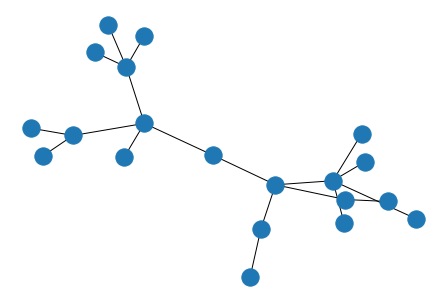

In [7]:
nx.draw(E, )

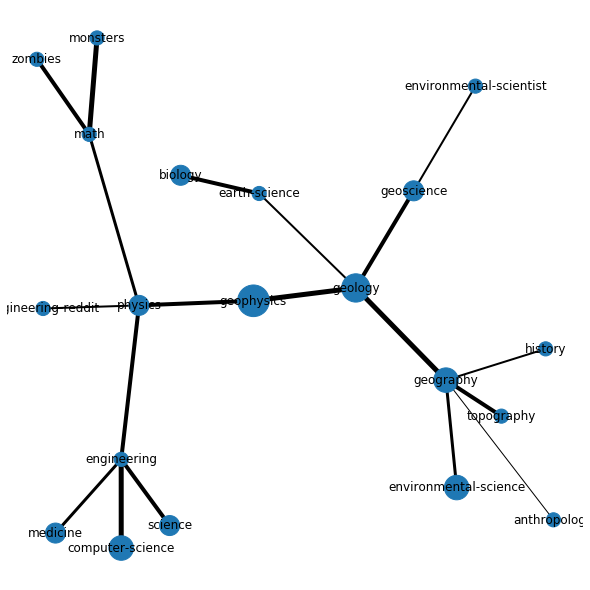

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

edges = E.edges()
weights = [E[u][v]['weight'] for u,v in edges]

counts = [200 * nx.get_node_attributes(E, 'count')[u] for u in E.nodes()]

params = {
    'node_size': counts,
    'with_labels': True,
    'width': weights,
}

pos = nx.spring_layout(E)

fig = plt.figure(figsize=(8, 8))
nx.draw(E, pos, **params)